# Module 4 :  Assignment 

## Setup 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import multiprocessing
from main import initialize_forest, get_neighbors

# Constants
GRID_SIZE = 800  # 800x800 forest grid
FIRE_SPREAD_PROB = 0.3  # Probability that fire spreads to a neighboring tree
BURN_TIME = 3  # Time before a tree turns into ash
DAYS = 60  # Maximum simulation time
NUM_SIMULATIONS = 10  # Number of independent simulations

# State definitions
EMPTY = 0    # No tree
TREE = 1     # Healthy tree 
BURNING = 2  # Burning tree 
ASH = 3      # Burned tree 

### Task 1.1 - Parallelization with Multiprocessing. Modify the wildfire simulation to run multiple independent simulations in parallel using the multiprocessing module. Parallelization Strategy:

1. Each wildfire simulation runs independently.
2. Use multiprocessing.Pool to distribute multiple simulations across CPU cores.
3. Aggregate results across multiple wildfire runs to analyze average fire spread.

In [3]:
def simulate_wildfire(simulation_id):
    """Simulates wildfire spread over time and returns the fire spread data."""
    forest, burn_time = initialize_forest()
    fire_spread = []  # Track number of burning trees each day

    for day in range(DAYS):
        new_forest = forest.copy()
        
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if forest[x, y] == BURNING:
                    burn_time[x, y] += 1  # Increase burn time
                    
                    # If burn time exceeds threshold, turn to ash
                    if burn_time[x, y] >= BURN_TIME:
                        new_forest[x, y] = ASH
                    
                    # Spread fire to neighbors
                    for nx, ny in get_neighbors(x, y):
                        if forest[nx, ny] == TREE and random.random() < FIRE_SPREAD_PROB:
                            new_forest[nx, ny] = BURNING
                            burn_time[nx, ny] = 1
        
        forest = new_forest.copy()
        fire_spread.append(np.sum(forest == BURNING))
        
        if np.sum(forest == BURNING) == 0:  # Stop if no more fire
            break
    
    return fire_spread

In [4]:
def run_parallel_simulations(num_simulations):
    """Runs multiple wildfire simulations in parallel and aggregates the results."""
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(simulate_wildfire, range(num_simulations))
    
    return results

In [ ]:
# Run simulations in parallel
fire_spread_results = run_parallel_simulations(NUM_SIMULATIONS)

# Aggregate results
max_length = max(len(result) for result in fire_spread_results)
fire_spread_avg = np.zeros(max_length)

for result in fire_spread_results:
    padded_result = np.pad(result, (0, max_length - len(result)), 'constant', constant_values=0)
    fire_spread_avg += padded_result

fire_spread_avg /= NUM_SIMULATIONS

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(len(fire_spread_avg)), fire_spread_avg, label="Average Burning Trees")
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title(f"Wildfire Spread Over Time (Avg of {NUM_SIMULATIONS} Runs)")
plt.legend()
plt.show()

To run on macOS run python task_1.py in the terminal 

Reason: Multiprocessing on macOS/Windows requires if __name__ == "__main__": This prevents worker processes from re-importing the module, which leads to the AttributeError: Can't get attribute 'simulate_wildfire'

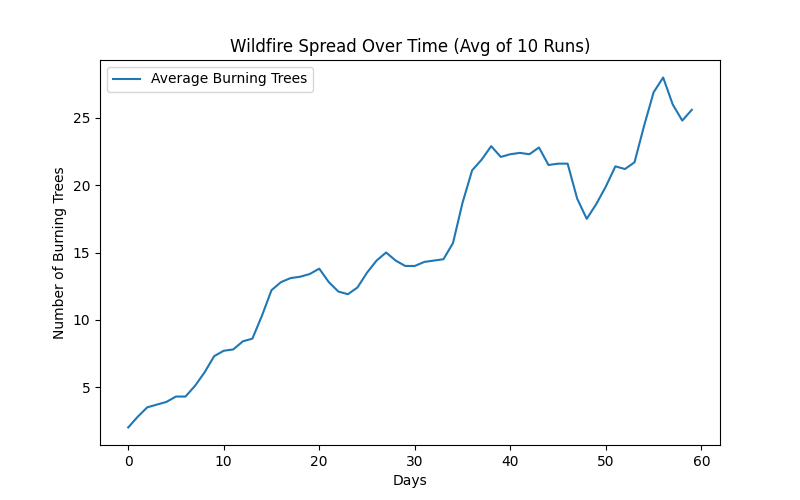

single simulation: 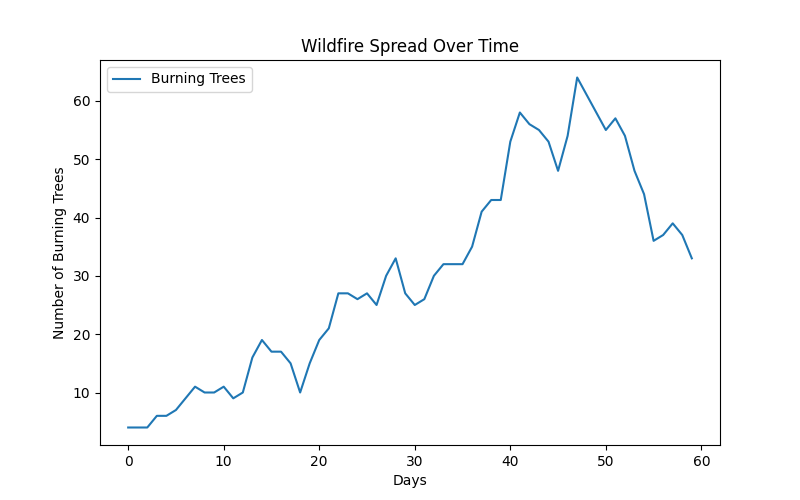

By running multiple wildfire simulations in parallel and aggregating the results, we obtain a more reliable and generalizable understanding of fire spread behavior. The individual simulation results show a high degree of variability—some fires spread rapidly and sustain for many days, while others burn out quickly, as seen in simulations like 6 and 9. The aggregated result smooths out these individual variations and provides an average trajectory, which is more representative of general wildfire dynamics rather than outliers. Compared to a single simulation (provided above), this approach prevents misleading conclusions that might arise from a particularly extreme or short-lived fire event, compare the y-axis for an example of such missinterpretation.

## Task 1.2: Parallelization with Dask. Further optimize the wildfire simulation using Dask, using the Dask Dashboard for performance monitoring. The parallelization strategy is the following:

1. Convert simulate_wildfire() into a Dask Delayed function.
2. Use Dask’s task scheduler to execute simulations efficiently.
3. Convert the results into a Dask Array for efficient aggregation.
4. Execute multiple simulations in parallel and compute the final result.
5. Use Dask.distributed and Dask Dashboard to monitor execution a runtime

In [ ]:
! python task_2.py 

Some problems encountered with the exercise: 

Dask workers keep crashing, likely due to a combination of:

- Running Matplotlib in worker threads
- Memory/resource exhaustion
- Port conflicts

Solution: 
- Remove all Matplotlib operations from simulate_wildfire()

Dask.Dashboard: 
- CPU Use (%) → Tracks how much CPU is utilized by the Dask workers.
> during the run of the algorithm the CPU was at ~100% as soon as execution was done this went down to 3% 
- Memory Use (%) → Shows the overall memory consumption of the workers.
> during execition this was around 200 MiB after execution this returned to around 114 MiB

if we increase the number of workers from the default 4 to 8 these stats change. The memory used goes down and the CPU usage is also reduced to ~80%. 
Research showed that the number of workers should be equal to or a bit less than the number of CPU cores. This means each person running the code should adapt this variable. 
Changing the number of threads leads to very unequal distribution of CPU usage, some workers working at ~2% while others are at ~100%. Thus we agree on leaving the number of threads at 2 and using around the number of cores available. 

The visualization of the graph was also fun to look at: 
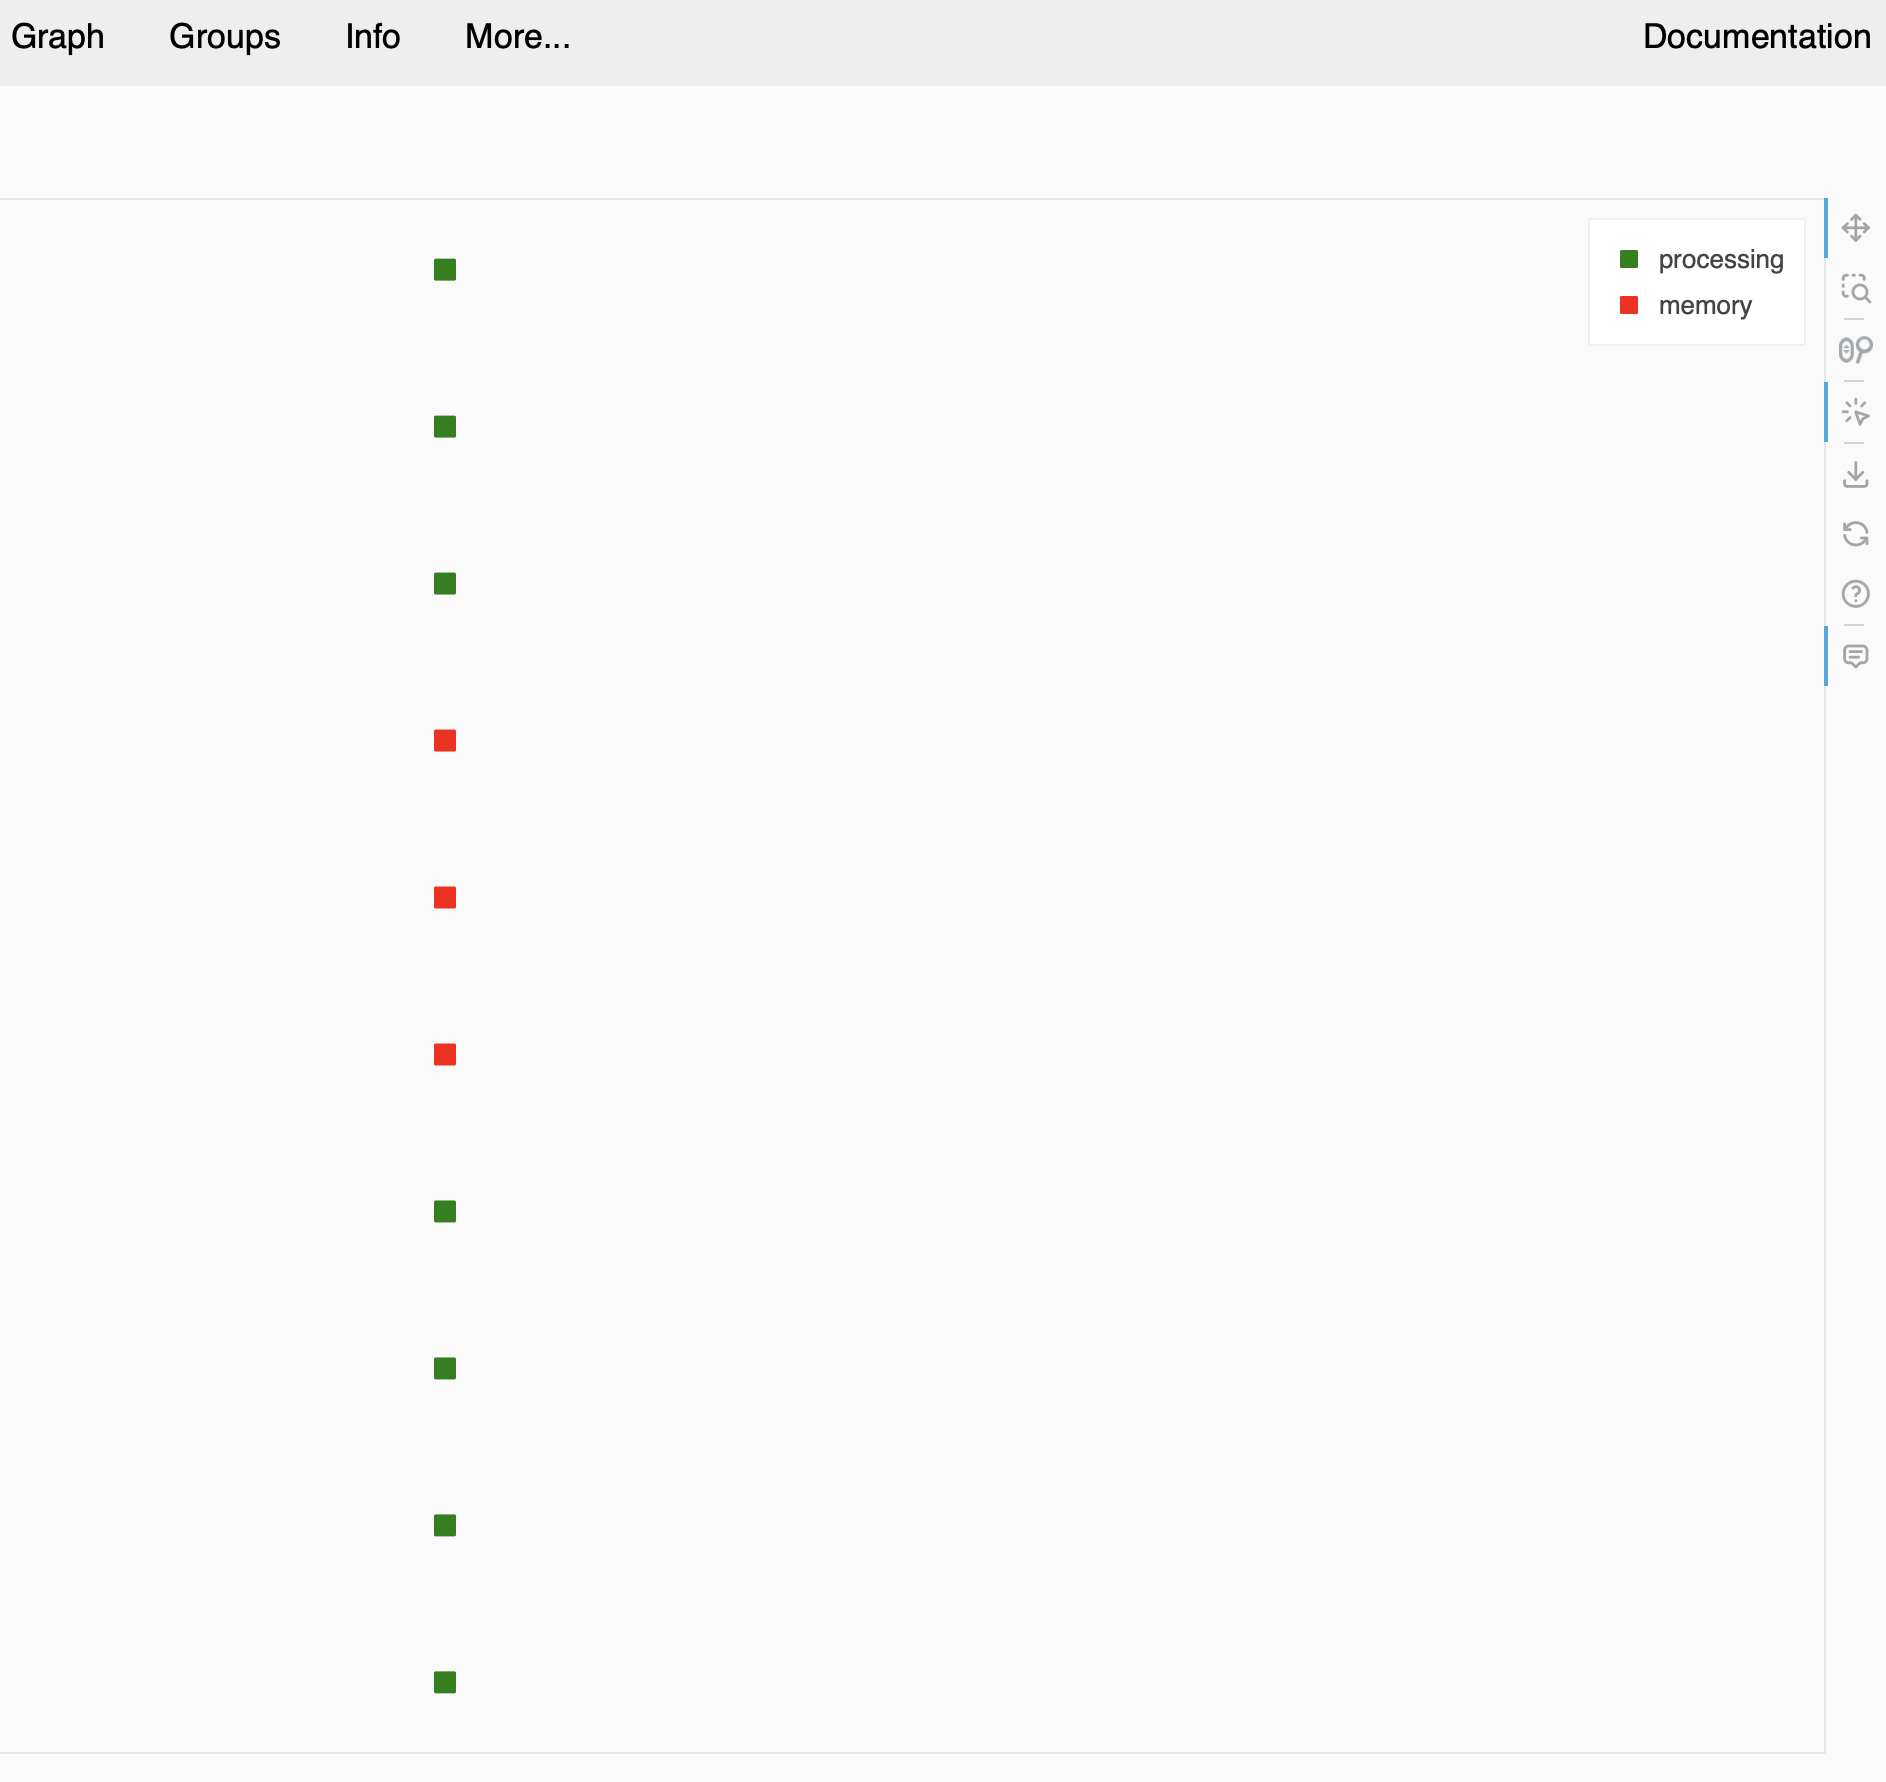

## Task 1.3: Performance Comparison. Measure execution time for:
Serial version, Multiprocessing version, and Dask version

In [8]:
! python task_3.py


Running Serial Execution...
Serial Execution Time: 23.17 seconds

Running Multiprocessing Execution...
Multiprocessing Execution Time: 7.46 seconds

Running Dask with 1 workers...
Execution Time with 1 workers: 29.17 sec

Running Dask with 2 workers...
Execution Time with 2 workers: 16.27 sec

Running Dask with 4 workers...
Execution Time with 4 workers: 6.00 sec

Running Dask with 8 workers...
Execution Time with 8 workers: 9.25 sec

Running Dask with 16 workers...
Execution Time with 16 workers: 6.21 sec

Running Dask with Optimal Workers...
Dask Execution Time: 5.68 seconds
Chunk Size 5: Execution Time = 0.02 sec
Chunk Size 20: Execution Time = 0.01 sec
Chunk Size 100: Execution Time = 0.00 sec
Figure(800x500)
Figure(800x500)

===== Performance Comparison =====
Serial Execution Time: 23.17 sec
Multiprocessing Execution Time: 7.46 sec
Dask Execution Time: 5.68 sec


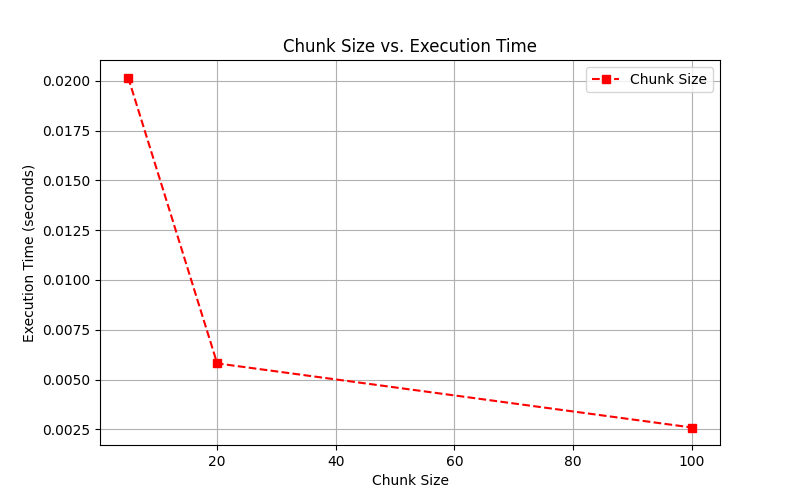
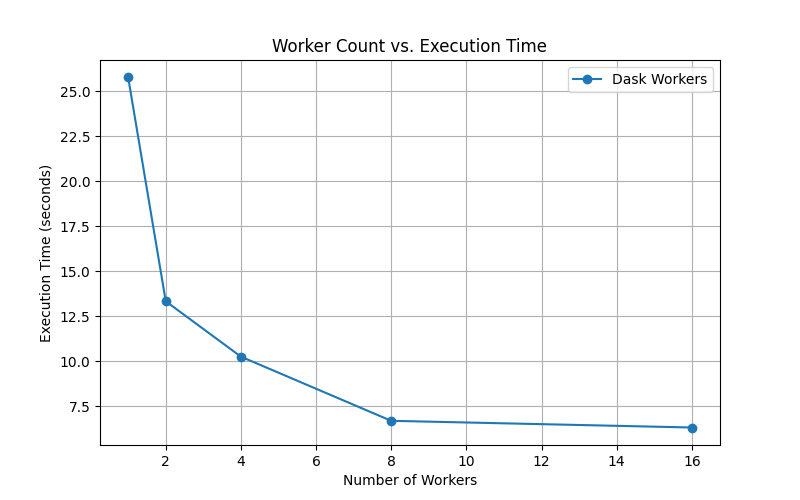

Results: 
Dask is currently the fastest, followed by multiprocessing and then serial execution. However, the performance difference between multiprocessing and Dask is relatively small (~2.3 sec). This suggests that Dask’s task scheduling and overhead are not significantly affecting performance negatively. 

How does chunk size affect performance?


# Task 1.4: Visualization with Paraview and VTK.

Write VTK files with grid information from the python code and visualize the time sequence using Paraview. Attach snapshots of your animation to your report. 

![Screenshot 2025-02-16 144923.png](<attachment:Screenshot 2025-02-16 144923.png>)
![Screenshot 2025-02-16 144939.png](<attachment:Screenshot 2025-02-16 144939.png>)
![Screenshot 2025-02-16 144952.png](<attachment:Screenshot 2025-02-16 144952.png>)
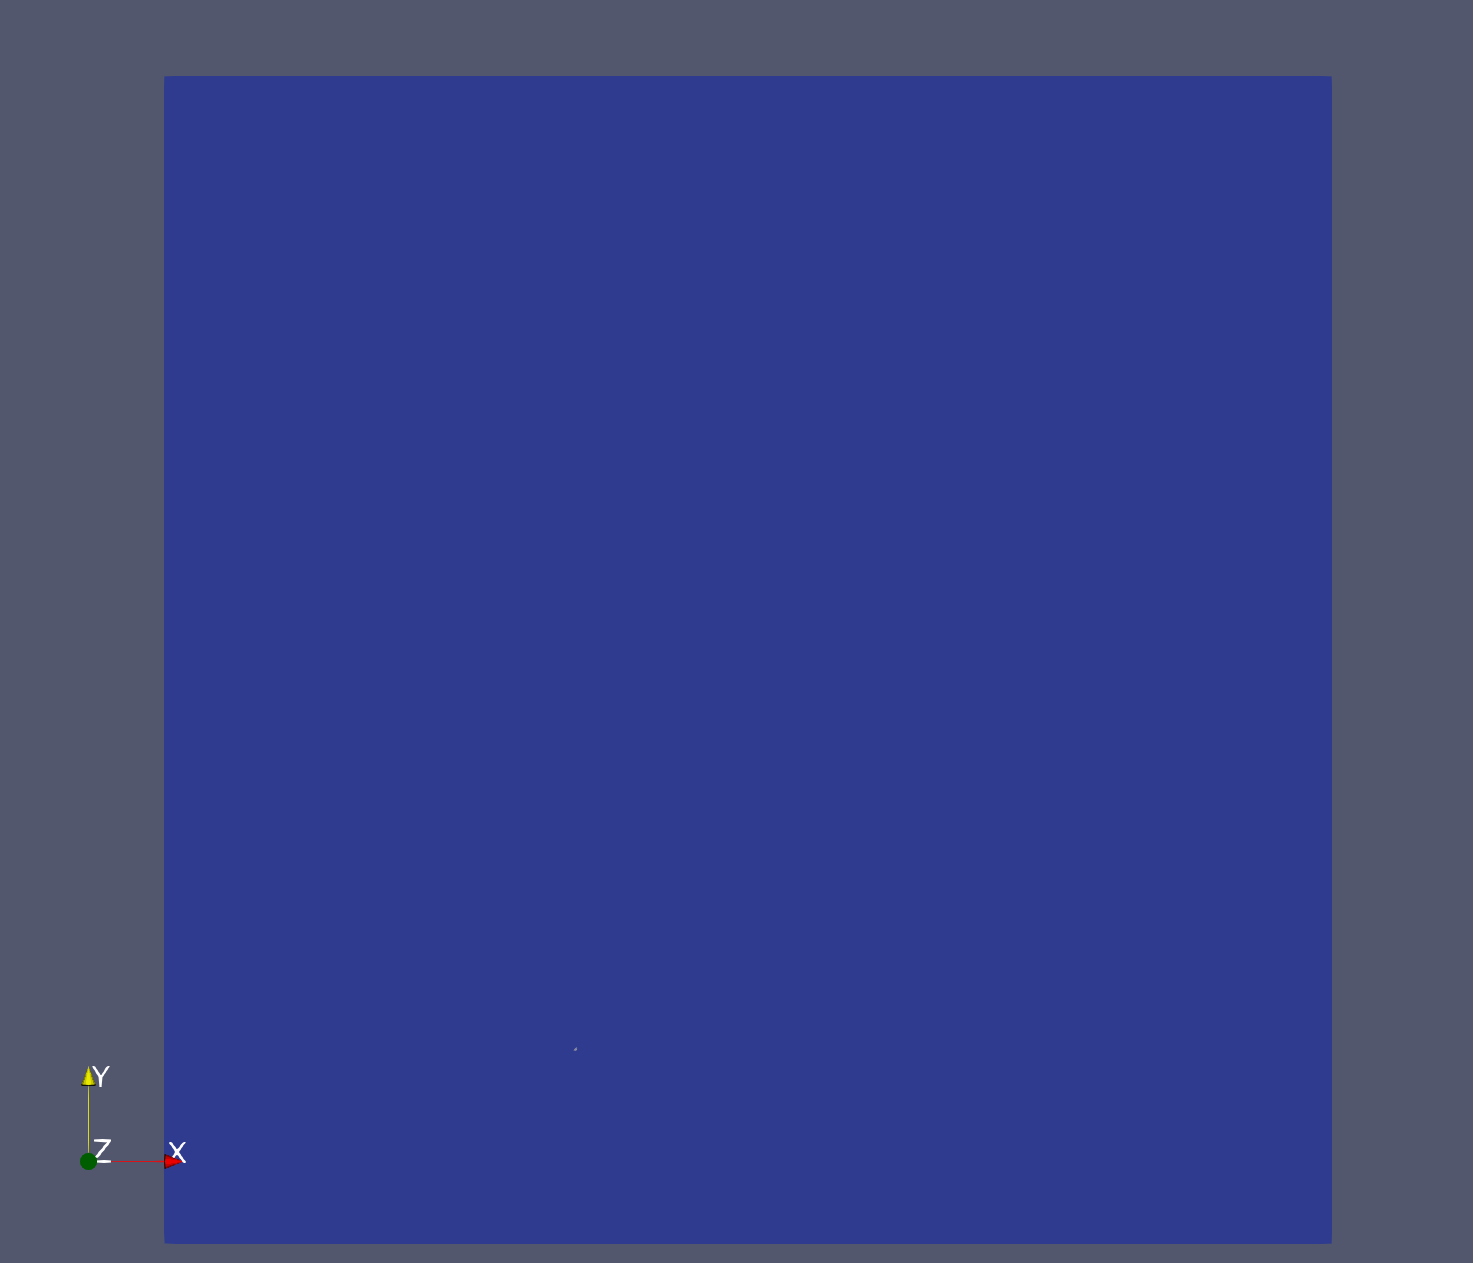
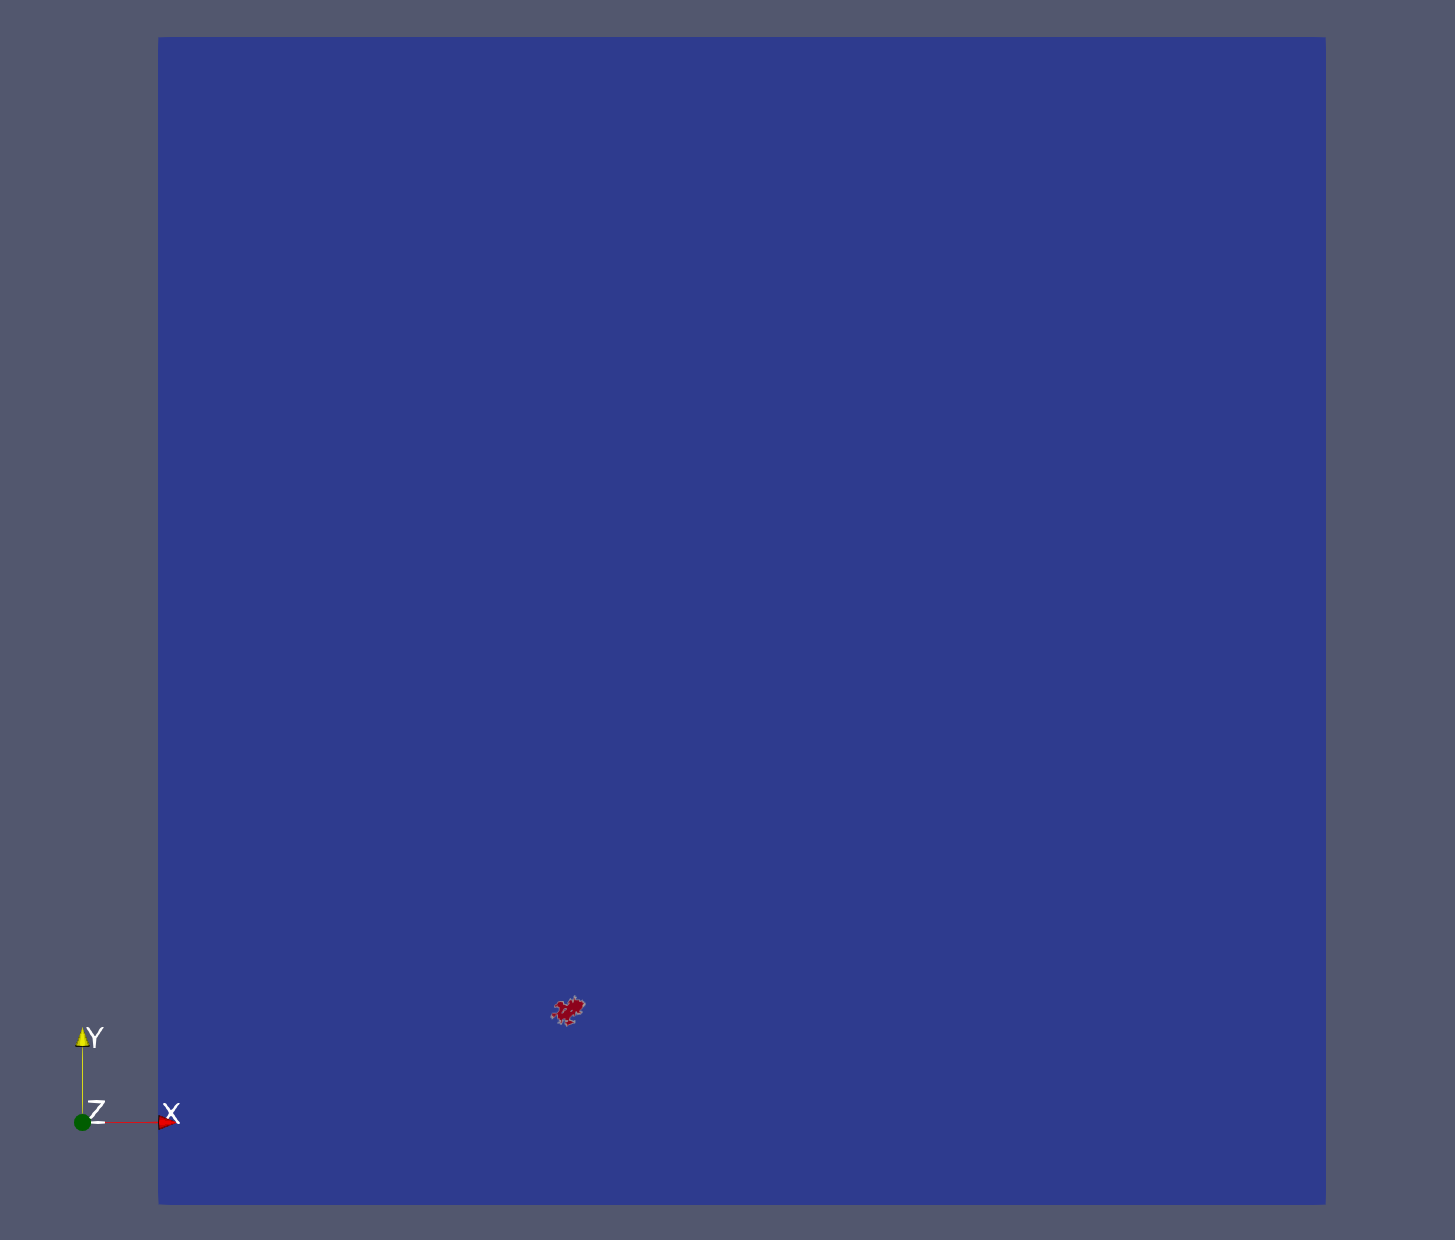
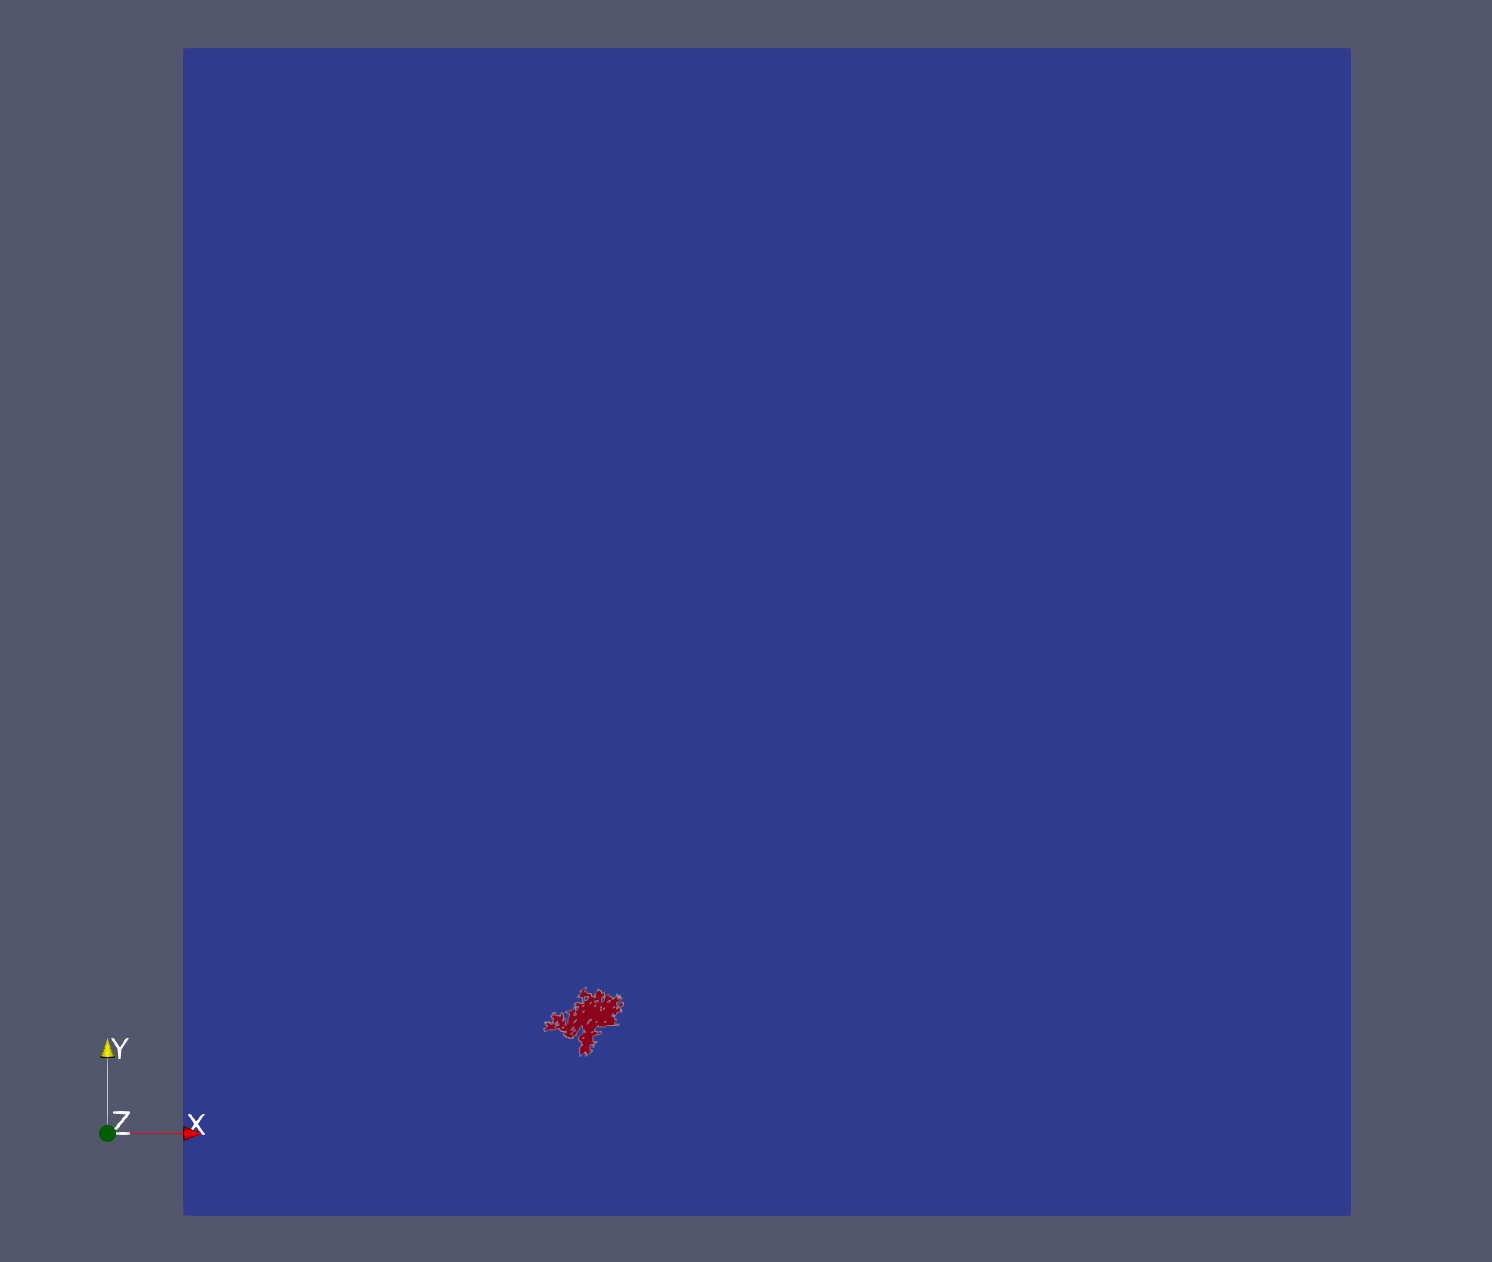

So I'm not really sure if I did this correctly, but you can try it yourself. We can also look at how it goes on monday!